# Nonlinear controller

[![Binder](https://static.mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/cghiaus/dm4bem_book/HEAD?labpath=%2Ftutorials%2Fpd06nonlin.ipynb)

This notebook shows how to change the control input during the numerical integration in order to implement complex control algorithms in the numerical integration loop. The procedure presented in [Inputs and simulation](pd05simulation.ipynb) is used with the difference that nonlinear control algorithms are implemented in the time-integration loop.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

In [2]:
def control_for(controller, period, dt=30, nonlinear_controller=True):
    # Obtain state-space representation
    # =================================
    # Disassembled thermal circuits
    folder_path = './pd/bldg'
    TCd = dm4bem.bldg2TCd(folder_path,
                          TC_auto_number=True)

    # Assembled thermal circuit
    ass_lists = pd.read_csv(folder_path + '/assembly_lists.csv')
    ass_matrix = dm4bem.assemble_lists2matrix(ass_lists)
    TC = dm4bem.assemble_TCd_matrix(TCd, ass_matrix)

    # TC['G']['c3_q0'] = 1e3  # Kp, controler gain
    # TC['C']['c2_θ0'] = 0    # indoor air heat capacity
    # TC['C']['c1_θ0'] = 0    # glass (window) heat capacit

    # State-space
    [As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)

    # Eigenvaleus analysis
    # ====================
    λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As

    dt_max = 2 * min(-1. / λ)    # max time step for Euler explicit stability
    dt_max = dm4bem.round_time(dt_max)
    # dm4bem.print_rounded_time('dt_max', dt)

    # Simulation with weather data
    # ============================
    # Start / end time
    start_date = period[0]
    end_date = period[1]

    start_date = '2000-' + start_date
    end_date = '2000-' + end_date

    # Weather
    filename = '../weather_data/FRA_Lyon.074810_IWEC.epw'
    [data, meta] = dm4bem.read_epw(filename, coerce_year=None)
    weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
    del data
    weather.index = weather.index.map(lambda t: t.replace(year=2000))
    weather = weather.loc[start_date:end_date]

    # Temperature sources
    To = weather['temp_air']

    Ti_day, Ti_night = 20, 16
    Ti_sp = pd.Series(20, index=To.index)
    Ti_sp = pd.Series(
        [Ti_day if 6 <= hour <= 22 else Ti_night for hour in To.index.hour],
        index=To.index)

    # Flow-rate sources
    # total solar irradiance
    wall_out = pd.read_csv('pd/bldg/walls_out.csv')
    w0 = wall_out[wall_out['ID'] == 'w0']

    surface_orientation = {'slope': w0['β'].values[0],
                           'azimuth': w0['γ'].values[0],
                           'latitude': 45}

    rad_surf = dm4bem.sol_rad_tilt_surf(
        weather, surface_orientation, w0['albedo'].values[0])

    Etot = rad_surf.sum(axis=1)

    # Window glass properties
    α_gSW = 0.38    # short wave absortivity: reflective blue glass
    τ_gSW = 0.30    # short wave transmitance: reflective blue glass
    S_g = 9         # m2, surface area of glass

    # Flow-rate sources
    # solar radiation
    Φo = w0['α1'].values[0] * w0['Area'].values[0] * Etot
    Φi = τ_gSW * w0['α0'].values[0] * S_g * Etot
    Φa = α_gSW * S_g * Etot

    # auxiliary (internal) sources
    Qa = pd.Series(0, index=To.index)

    # Input data set
    input_data_set = pd.DataFrame({'To': To, 'Ti_sp': Ti_sp,
                                   'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa,
                                   'Etot': Etot})

    # Time integration
    # ----------------
    # Resample hourly data to time step dt
    input_data_set = input_data_set.resample(
        str(dt) + 'S').interpolate(method='linear')

    # Get input from input_data_set
    u = dm4bem.inputs_in_time(us, input_data_set)

    # initial conditions
    θ0 = 20                     # initial temperatures
    θ_exp = pd.DataFrame(index=u.index)
    θ_exp[As.columns] = θ0      # Fill θ with initial valeus θ0

    # time integration
    I = np.eye(As.shape[0])     # identity matrix

    for k in range(1, u.shape[0] - 1):
        if nonlinear_controller:
            exec(controller)

        θ_exp.iloc[k + 1] = (I + dt * As)\
            @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]

    # outputs
    y = (Cs @ θ_exp.T + Ds @  u.T).T

    Kp = TC['G']['c3_q0']     # W/K, controller gain
    S = 3 * 3                 # m², surface area of the toy house

    # q_HVAC / [W/m²]
    if nonlinear_controller:
        q_HVAC = u['c2_θ0']
    else:
        q_HVAC = Kp * (u['c3_q0'] - y['c2_θ0']) / S  # W/m²

    # plot
    data = pd.DataFrame({'To': input_data_set['To'],
                         'θi': y['c2_θ0'],
                         'Etot': input_data_set['Etot'],
                         'q_HVAC': q_HVAC})

    fig, axs = plt.subplots(2, 1, sharex=True)
    data[['To', 'θi']].plot(ax=axs[0],
                            xticks=[],
                            ylabel='Temperature, $θ$ / [°C]')
    axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
                  loc='upper right')
    axs[0].grid(True)

    data[['Etot', 'q_HVAC']].plot(ax=axs[1],
                                  ylabel='Heat rate, $q$ / [W / m²]')
    axs[1].set(xlabel='Time')
    axs[1].legend(['$E_{total}$', '$q_{HVAC}$'],
                  loc='upper right')
    axs[1].grid(True)
    plt.show()

## Model

![assambled_TC](./pd/bldg/ass_TC.svg)
> Figure 1. Assembled circuit.

In this example, we will consider that the controller is not modeled by the conductance $G_0$ and the temperature source $T_{i,sp}$ of circuit `TC3:c3` but, instead, by the heatflow rate $\dot{Q}_a$, which is added to the indoor air in node $\theta_0$ of circuit `TC2:c2`  (Figure 1). Therefore, in `TC3:c3` the conductance $G_0 \rightarrow 0$ and

$$\dot{Q}_a \equiv u_{c2\_θ0} = K_p (T_{i,sp} - \theta_{c2\_θ0})$$

where:
- $\dot{Q}_a$ - auxiliary heat in node `θ0` of circuit `c2`, W;
- $u_{c2\_θ0}$ - input of type flow rate source in node `θ0` of circuit `c2`, W;
- $K_p$ - static gain of the proportional controller, W/°C;
- $T_{i,sp}$ - indoor temperature setpoint, °C;
- $\theta_{c2\_θ0}$ - indoor temperature, which is the temperature node `θ0` of circuit `c2`, °C.

## Free running

The model can be simulated in free-runinng when there is no nonlinear controller (i.e., $\dot{Q}_a = 0$).

In [3]:
start_date = '02-01 12:00:00'
end_date = '02-03 18:00:00'
period = [start_date, end_date]

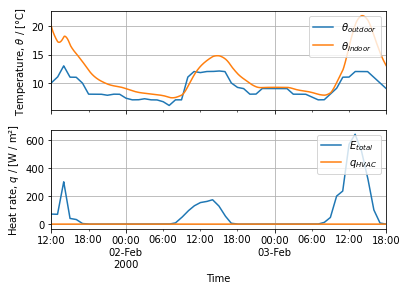

In [4]:
control_for("free running", period, dt=30,
            nonlinear_controller=False)

> Figure 2. Free-running (i.e., no controller).

## Heating

In heating, the auxiliary heat flow $\dot{Q}_a \equiv u_{c2\_θ0}$ is zero if the indoor air temperature $\theta_{c2\_θ0}$ is higher than its setpoint $T_{i,sp}$. Otherwise, the input is

$$u_{c2\_θ0} = K_p (T_{i,sp} - \theta_{c2\_θ0})$$

if $u_{c2\_θ0} > 0$.

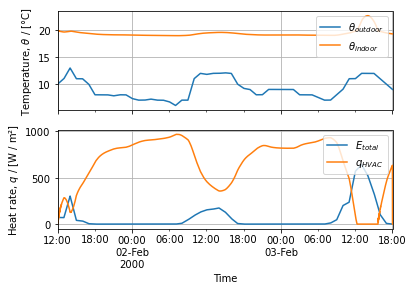

In [5]:
heating = """
Tisp = 20   # indoor setpoint temperature, °C
Kpp = 1e3   # controller gain

if Tisp < θ_exp.iloc[k - 1]['c2_θ0']:
    u.iloc[k]['c2_θ0'] = 0
else:
    u.iloc[k]['c2_θ0'] = Kpp * (Tisp - θ_exp.iloc[k - 1]['c2_θ0'])
"""

control_for(heating, period)

> Figure 3. Heating.

## Cooling

In cooling, the auxiliary heat flow $\dot{Q}_a \equiv u_{c2\_θ0}$ is zero if the indoor air temperature $\theta_{c2\_θ0}$ is lower than its setpoint $T_{i,sp}$. Otherwise, the input is

$$u_{c2\_θ0} = K_p (T_{i,sp} - \theta_{c2\_θ0})$$

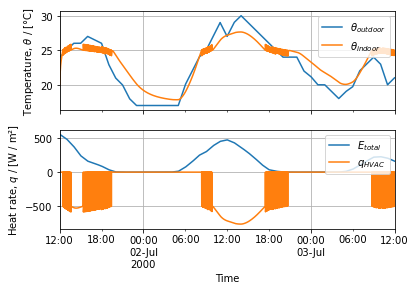

In [6]:
cooling = """
Tisp = 20   # indoor setpoint temperature, °C
Δθ = 5      # temperature deadband, °C
Kpp = 1e2   # controller gain

if θ_exp.iloc[k - 1]['c2_θ0'] < Tisp + Δθ :
    u.iloc[k]['c2_θ0'] = 0
else:
    u.iloc[k]['c2_θ0'] = Kpp * (Tisp - θ_exp.iloc[k - 1]['c2_θ0'])
"""
period = ['07-01 12:00:00', '07-03 12:00:00']
control_for(cooling, period)

> Figure 4. Cooling.

## Heating and cooling with deadband

During mid-season, heating and cooling may be required. In this case a [deadband](https://en.m.wikipedia.org/wiki/Deadband) controller is preferred to a perfect controller (see [Inputs and simulation](pd05simulation.ipynb)). In deadband controller, the auxiliary heat flow $\dot{Q}_a \equiv u_{c2\_θ0}$ is zero if the indoor air temperature $\theta_{c2\_θ0}$ is higher than its setpoint $T_{i,sp}$ but lower than the setpoint plus the deadband $\Delta \theta$. Otherwise, the input is

$$u_{c2\_θ0} = K_p (T_{i,sp} - \theta_{c2\_θ0})$$


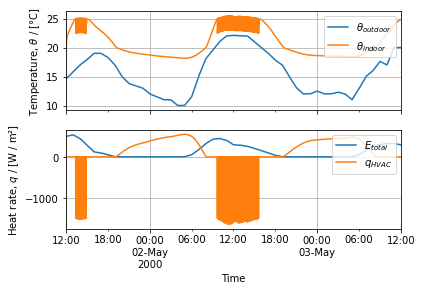

In [7]:
heat_cool = """
Tisp = 20   # indoor setpoint temperature, °C
Δθ = 5      # temperature deadband, °C
Kpp = 3e2   # controller gain

if Tisp < θ_exp.iloc[k - 1]['c2_θ0'] < Tisp + Δθ:
    u.iloc[k]['c2_θ0'] = 0
else:
    u.iloc[k]['c2_θ0'] = Kpp * (Tisp - θ_exp.iloc[k - 1]['c2_θ0'])
"""
period = ['05-01 12:00:00', '05-03 12:00:00']
control_for(heat_cool, period)

> Figure 5. Heating and cooling with deadband.

## Solar protection

The [cooling load](https://en.m.wikipedia.org/wiki/Cooling_load) can be reduced by solar protection. In our example, let's assume that if the indoor temperature is higher than its setpoint, [exterior shutters](https://en.m.wikipedia.org/wiki/Window_shutter) are closed. To model this, the flow rate $\Phi_i$ in node $\theta_4$ of thermal circuit `walls_out: ow0`, i.e. $u_{ow0\_θ4}$ (Figure 1), is reduced at 10 % of its value.

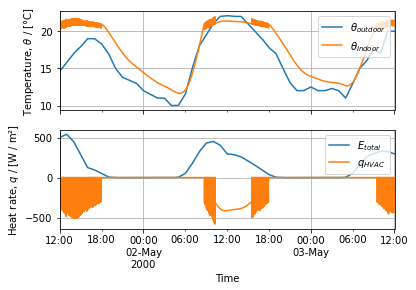

In [8]:
solar = """
Tisp = 20   # indoor setpoint temperature, °C
Δθ = 1      # temperature deadband, °C
Kpp = 3e2   # controller gain

if θ_exp.iloc[k - 1]['c2_θ0'] < Tisp + Δθ:
    u.iloc[k]['c2_θ0'] = 0
else:
    u.iloc[k]['c2_θ0'] = Kpp * (Tisp - θ_exp.iloc[k - 1]['c2_θ0'])
    u.iloc[k]['c2_θ0'] = min(u.iloc[k]['c2_θ0'], 0)
    u.iloc[k]['ow0_θ4'] *= 0.1
"""

period = ['05-01 12:00:00', '05-03 12:00:00']
control_for(solar, period)

> Figure 6. Cooling load is reduced by solar protection.

## Passive cooling

In mid-season, the building may be cooled by using [passive cooling](https://en.m.wikipedia.org/wiki/Passive_cooling) such as solar protection with [window shutters](https://en.m.wikipedia.org/wiki/Window_shutter) and [free cooling](https://en.m.wikipedia.org/wiki/Free_cooling).

Free-cooling is modeled by increasing the [air changes per hour](https://en.m.wikipedia.org/wiki/Air_changes_per_hour) (ACH). In our example, they increase from 1 ACH to 10 ACH and the cooling is turned off, `u.iloc[k]['c2_θ0'] = 0`.

The thermal conductance for free-cooling by ventilation is

$$G_{free} = \dot{m}_a c_a  = \rho_a c_a \dot{V}_a$$

where:
- $\dot{m}_a$ is the [mass flow rate](https://en.m.wikipedia.org/wiki/Mass_flow_rate) of air, kg/s;
- $\dot{V}_a$ - [volumetric flow rate](https://en.m.wikipedia.org/wiki/Volumetric_flow_rate), m³/s;
- $c_a$ - [specific heat capacity](https://en.m.wikipedia.org/wiki/Specific_heat_capacity) of the air, J/kg·K;
- $\rho_a$ - [density](https://en.m.wikipedia.org/wiki/Density) of air, kg/m³.

The [volumetric flow rate](https://en.m.wikipedia.org/wiki/Volumetric_flow_rate) of the air, in m³/s, is:

$$\dot{V}_a = \frac{\mathrm{ACH}}{3600} V_a$$

where:
- $\mathrm{ACH}$  ([air changes per hour](https://en.m.wikipedia.org/wiki/Air_changes_per_hour)) is the air infiltration rate, 1/h;
- $3600$ - number of seconds in one hour, s/h;
- $V_a$ - volume of the air in the thermal zone, m³.

The net flow rate that the building receives by [advection](https://en.m.wikipedia.org/wiki/Advection), i.e., introducing outdoor air at temperature $T_o$ and extracting indoor air at temperature $\theta_i$ by [ventilation](https://en.m.wikipedia.org/wiki/Ventilation_(architecture)), is:

$$q_{free} = G_{free} (T_o - \theta_i)$$

- $T_o$ - outdoor air temperature, °C, is `u['ow0_q0']` (Figure 1);
- $\theta_i$ - indoor air temperature, °C, is `θ_exp['c2_θ0']`.

Modifying the conductance for advection, $G_0$ in thermal circuit `TC2: c2` (Figure 1) implies recalculating the state-space model. As an altenative, we can consider that a flow rate,

$$q_{free} = G_{free} (T_o - \theta_i)$$

impelented as `q_free = G_free * (u['ow0_q0'] - θ_exp['c2_θ0'])`, is added to $Q_a$, which is input `u['c2_θ0']` (Figure 1). 

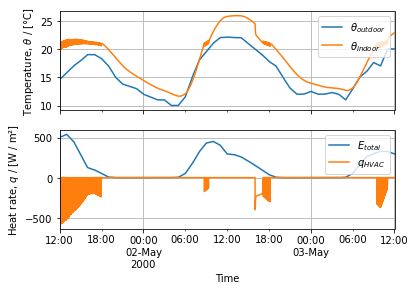

In [9]:
passive_cooling = """
Tisp = 20                   # indoor setpoint temperature, °C
Δθ = 1                      # temperature deadband, °C
Kpp = 3e2                   # controller gain

# ventilation flow rate
l = 3                       # m length of the cubic room
Va = l**3                   # m³, volume of air
ACH = 10                    # 1/h, air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s, air infiltration
ρ = 1.2                     # kg/m³
c = 1000                    # J/(kg·K)
G_free = ρ * c * Va_dot
q_free = G_free * (u.iloc[k - 1]['ow0_q0'] - θ_exp.iloc[k - 1]['c2_θ0'])

if θ_exp.iloc[k - 1]['c2_θ0'] < Tisp + Δθ:
    u.iloc[k]['c2_θ0'] = 0
else:
    u.iloc[k]['c2_θ0'] = 0
    if u.iloc[k - 1]['ow0_q0'] < Tisp:
        u.iloc[k]['c2_θ0'] = q_free
    u.iloc[k]['ow0_θ4'] *= 0.1
"""

period = ['05-01 12:00:00', '05-03 12:00:00']
control_for(passive_cooling, period)

> Figure . Solar protection and free-cooling. The coling load is "free" because it represents fresh airflow from outdoors.